## 14th July 2025 
### API Cbioportal Data Exploration
### 

In [22]:
import pandas as pd #this is to manipulate the data
import requests
import pandas as pd
!pip install biopython
from Bio import Entrez
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import ast  # to safely parse stringified lists
import os

In [24]:
BASE_URL = "https://www.cbioportal.org/api"            # Base for API request                
HEADERS = {"accept": "application/json", "Content-Type": "application/json"}   #jsom formatted data

study_id = "prad_tcga_pan_can_atlas_2018"                     #study identifier
sample_list_id = "prad_tcga_pan_can_atlas_2018_all"           # list of sample identifier

# GET SAMPLE ID
samples_url = f"{BASE_URL}/sample-lists/{sample_list_id}"     #retrieve sample list 
samples_resp = requests.get(samples_url, headers=HEADERS)     #send request to the url
samples_resp.raise_for_status()                               #checck if request is successful
sample_ids = samples_resp.json().get("sampleIds", [])         #extracts the sample ID
print(f" Found {len(sample_ids)} samples in {sample_list_id}")

 Found 494 samples in prad_tcga_pan_can_atlas_2018_all


In [26]:
# Converting HUGO → Entrez IDs via Bio-python
def get_entrez_ids_biopython(hugo_list):    #define a function   
    entrez_ids = {}                         #create empty dictionary to store
    for gene in hugo_list:                  #iterate through the gene symbol list
        handle = Entrez.esearch(db="gene", term=f"{gene}[Gene Name] AND Homo sapiens[Organism]")   #search query against NCBI database
        record = Entrez.read(handle)        #reads the search0
        handle.close()                      #close ncbi connection
        if record["IdList"]:                # if an ID is found
            entrez_ids[gene] = int(record["IdList"][0]) #convert the first one to an integer and store as entrez ID
        else:
            entrez_ids[gene] = None
            print(f"No match found for {gene}")
    return entrez_ids

# MAPK pathway genes
hugo_genes = [
    "EGFR","KRAS","HRAS","NRAS",
    "ARAF","BRAF","RAF1",
    "MAP2K1","MAP2K2",
    "MAPK1","MAPK3",
    "KSR1","KSR2"
]
entrez_map = get_entrez_ids_biopython(hugo_genes)          #Call function
entrez_ids = [eid for eid in entrez_map.values() if eid is not None]        
print("Converted HUGO → Entrez IDs:", entrez_map)




C:\Users\peace\anaconda3\Lib\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


Converted HUGO → Entrez IDs: {'EGFR': 1956, 'KRAS': 3845, 'HRAS': 3265, 'NRAS': 4893, 'ARAF': 369, 'BRAF': 673, 'RAF1': 5894, 'MAP2K1': 5604, 'MAP2K2': 5605, 'MAPK1': 5594, 'MAPK3': 5595, 'KSR1': 8844, 'KSR2': 22866}


In [28]:
# ==== Molecular profiles ====
molecular_profiles = {
    "cna_log2": "prad_tcga_pan_can_atlas_2018_log2CNA",
    "mrna": "prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna",
    "mrna_zscores": "prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna_median_all_sample_Zscores"
}
#create a dictionary for  moleculat value.

# Molecular data
def fetch_molecular_data(profile_id, samples, entrez_ids):               #function to get molecular data
    url = f"{BASE_URL}/molecular-profiles/{profile_id}/molecular-data/fetch"       #url for cBioportal API to get molecular data 
    payload = {"entrezGeneIds": entrez_ids, "sampleIds": samples}         #Dictionary to know ganes and samples i need data
    resp = requests.post(url, headers=HEADERS, json=payload)              #Post requestfor the gene and sample ID
    if resp.status_code == 200:
        df = pd.DataFrame(resp.json())                                   #convert to a dataframe using pandas 
        print(f"Retrieved {df.shape[0]} rows from {profile_id}")          
        return df
    else:
        print(f" Error fetching {profile_id}: {resp.status_code}")
        print(resp.text)
        return pd.DataFrame()

molecular_dfs = {}                    #Create dictionary to store dataframe
for name, profile_id in molecular_profiles.items():      # iterate through the name cna, mrna
    df = fetch_molecular_data(profile_id, sample_ids, entrez_ids)
    molecular_dfs[name] = df
    if not df.empty:
        df.to_csv(f"{name}.csv", index=False)
        print(f"Saved {name}.csv")


timeline_url = f"{BASE_URL}/studies/{study_id}/clinical-events"
timeline_resp = requests.get(timeline_url, headers=HEADERS)
if timeline_resp.status_code == 200:
    df_timeline = pd.DataFrame(timeline_resp.json())
    print(f" Retrieved {df_timeline.shape[0]} treatment timeline events")
    print("Timeline columns:", list(df_timeline.columns))
    df_timeline.to_csv(f"{study_id}_treatment_timeline.csv", index=False)
    print(f"Saved {study_id}_treatment_timeline.csv")
else:
    print("Error fetching timeline:", timeline_resp.status_code, timeline_resp.text)


clinical_url = f"{BASE_URL}/studies/{study_id}/clinical-data"
clinical_resp = requests.get(clinical_url, headers=HEADERS)
if clinical_resp.status_code == 200:
    df_clinical = pd.DataFrame(clinical_resp.json())
    print(f" Retrieved {df_clinical.shape[0]} patients, {df_clinical.shape[1]} columns")
    print(" Clinical columns:", list(df_clinical.columns))
    df_clinical.to_csv(f"{study_id}_clinical_data.csv", index=False)
    print(f"Saved FULL {study_id}_clinical_data.csv")
else:
    print("Error fetching clinical data:", clinical_resp.status_code, clinical_resp.text)

print("- cna_log2.csv")
print("- mrna.csv")
print("- mrna_zscores.csv")
print(f"- {study_id}_treatment_timeline.csv")
print(f"- {study_id}_clinical_data.csv")


Retrieved 6357 rows from prad_tcga_pan_can_atlas_2018_log2CNA
Saved cna_log2.csv
Retrieved 6409 rows from prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna
Saved mrna.csv
Retrieved 6409 rows from prad_tcga_pan_can_atlas_2018_rna_seq_v2_mrna_median_all_sample_Zscores
Saved mrna_zscores.csv
 Retrieved 2262 treatment timeline events
Timeline columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'attributes', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis']
Saved prad_tcga_pan_can_atlas_2018_treatment_timeline.csv
 Retrieved 8854 patients, 7 columns
 Clinical columns: ['uniqueSampleKey', 'uniquePatientKey', 'sampleId', 'patientId', 'studyId', 'clinicalAttributeId', 'value']
Saved FULL prad_tcga_pan_can_atlas_2018_clinical_data.csv
- cna_log2.csv
- mrna.csv
- mrna_zscores.csv
- prad_tcga_pan_can_atlas_2018_treatment_timeline.csv
- prad_tcga_pan_can_atlas_2018_clinical_data.csv


## Identification of Gene and Treatment Data

In [30]:
cna_df=pd.read_csv("cna_log2.csv")
mrna_df=pd.read_csv("mrna_zscores.csv")
clinical_df=pd.read_csv("prad_tcga_pan_can_atlas_2018_clinical_data.csv")

#saving to working Directory as CSV
#cna_df.to_csv("cna_log2.csv", index=False)
#mrna_df.to_csv("mrna_zscores.csv", index=False)
#clinical_df.to_csv("prad_tcga_pan_can_atlas_2018_clinical_data.csv", index=False)

# Saving to working directory as Excel
#cna_df.to_excel("cna_log2.xlsx", index=False)
#mrna_df.to_excel("mrna_zscores.xlsx", index=False)
#clinical_df.to_excel("prad_tcga_pan_can_atlas_2018_clinical_data.xlsx", index=False)

In [13]:
# Loading the  treatment timeline data
treatment_df = pd.read_csv("prad_tcga_pan_can_atlas_2018_treatment_timeline.csv")

print("Loaded timeline shape:", treatment_df.shape)
print("Current columns:", treatment_df.columns.tolist())


Loaded timeline shape: (2262, 7)
Current columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'attributes', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis']


In [32]:
# Loading the  treatment timeline data
treatment_df = pd.read_csv("prad_tcga_pan_can_atlas_2018_treatment_timeline.csv")

print("Loaded timeline shape:", treatment_df.shape)
print("Current columns:", treatment_df.columns.tolist())

# Function to flatten attributes 
def flatten_timeline(df):
    expanded_rows = []

    for _, row in df.iterrows():
        base_data = row.drop("attributes").to_dict() #all other columns

        #parse the 'attributes' column (its stored as a sting in csv)
        try:
            attr_list = ast.literal_eval(row["attributes"]) if pd.notna(row["attributes"]) else []
        except Exception:
            attr_list = []

        #convert list of dicts to single dict
        if isinstance(attr_list, list):
            attr_data ={attr["key"]: attr["value"] for attr in attr_list}
        else:
            attr_data = {}

        #combine base + expanded attributes 
        expanded_rows.append({**base_data, **attr_data})

    return pd.DataFrame(expanded_rows)


#  Flatten it 
df_flat_timeline = flatten_timeline(treatment_df)

print(" Flattened timeline shape:", df_flat_timeline.shape)
print(" New columns:", df_flat_timeline.columns.tolist())

# Save flattened version
df_flat_timeline.to_csv("prad_tcga_pan_can_atlas_2018_treatment_timeline_flat.csv", index=False)
print(" Saved flattened version → prad_tcga_pan_can_atlas_2018_treatment_timeline_flat.csv")

df_flat_timeline.to_excel("prad_tcga_pan_can_atlas_2018_treatment_timeline_flat.xlsx", index=False)


Loaded timeline shape: (2262, 7)
Current columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'attributes', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis']
 Flattened timeline shape: (2262, 51)
 New columns: ['uniquePatientKey', 'studyId', 'patientId', 'eventType', 'startNumberOfDaysSinceDiagnosis', 'endNumberOfDaysSinceDiagnosis', 'SUBMITTED_FOR_LCE', 'TOP_SLIDE_SUBMITTED', 'TUMOR_NUCLEI_PERCENT', 'COUNTRY', 'METHOD_OF_SAMPLE_PROCUREMENT', 'VESSEL_USED', 'SAMPLE_PRESCREENED', 'TUMOR_WEIGHT', 'TUMOR_NECROSIS_PERCENT', 'SAMPLE_ID', 'STATUS', 'GLEASON_SECONDARY_PATTERN', 'PSA_VALUE', 'PATHOLOGIC_T', 'CLINICAL_M', 'GLEASON_SCORE', 'GLEASON_TERTIARY_PATTERN', 'GLEASON_PRIMARY_PATTERN', 'DAYS_TO_PSA', 'INITIAL_PATHOLOGIC_DIAGNOSIS_METHOD', 'PATHOLOGIC_N', 'VITAL_STATUS', 'CLINICAL_T', 'AGENT', 'TREATMENT_TYPE', 'MEASURE_OF_RESPONSE', 'TX_ON_CLINICAL_TRIAL', 'THERAPY_ONGOING', 'ANATOMIC_TREATMENT_SITE', 'RADIATION_TREATMENT_ONGOING', 'RADIATION_TYPE', 'RADIA

In [34]:
def entrez_to_hugo_biopython(entrez_ids):
    mapping = {}
    for eid in entrez_ids:
        try:
            handle = Entrez.esummary(db="gene", id=str(eid))
            record = Entrez.read(handle)
            handle.close()

            if record and "DocumentSummarySet" in record:
                docs = record["DocumentSummarySet"]["DocumentSummary"]
                if docs:
                    mapping[eid] = docs[0]["NomenclatureSymbol"]  # HUGO symbol
        except Exception as e:
            print(f"Could not fetch for {eid}: {e}")
    return mapping

# Get unique Entrez IDs from your data
unique_entrez_ids = mrna_df["entrezGeneId"].unique().tolist()

# Fetch mapping
entrez_to_hugo_map = entrez_to_hugo_biopython(unique_entrez_ids)

print(f" Retrieved {len(entrez_to_hugo_map)} gene symbols")


C:\Users\peace\anaconda3\Lib\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(


 Retrieved 13 gene symbols


In [36]:
mrna_df["hugoGeneSymbol"] = mrna_df["entrezGeneId"].map(entrez_to_hugo_map)

# Reorder columns for readability
cols = ["hugoGeneSymbol", "entrezGeneId"] + [c for c in mrna_df.columns if c not in ["hugoGeneSymbol", "entrezGeneId"]]
mrna_df = mrna_df[cols]
mrna_df.head()

cna_df["hugoGeneSymbol"] = cna_df["entrezGeneId"].map(entrez_to_hugo_map)

# Reorder columns for readability
cols = ["hugoGeneSymbol", "entrezGeneId"] + [c for c in mrna_df.columns if c not in ["hugoGeneSymbol", "entrezGeneId"]]
cna_df = cna_df[cols]
cna_df.head()



,hugoGeneSymbol,entrezGeneId,uniqueSampleKey,uniquePatientKey,molecularProfileId,sampleId,patientId,studyId,value
0,ARAF,369,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,-0.016
1,BRAF,673,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.001
2,EGFR,1956,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.001
3,HRAS,3265,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.010
4,KRAS,3845,VENHQS0yQS1BOFZMLTAxOnByYWRfdGNnYV9wYW5fY2FuX2...,VENHQS0yQS1BOFZMOnByYWRfdGNnYV9wYW5fY2FuX2F0bG...,prad_tcga_pan_can_atlas_2018_log2CNA,TCGA-2A-A8VL-01,TCGA-2A-A8VL,prad_tcga_pan_can_atlas_2018,0.001


In [38]:
# Transpose mRNA
mrna_trans_df = (
    mrna_df
    .pivot(index="sampleId", columns="hugoGeneSymbol", values="value")  # reshape long → wide
    .reset_index()
    .rename(columns={"sampleId": "Sample_ID"})
)
# Add patient-level ID
mrna_trans_df["PATIENT_ID"] = mrna_trans_df["Sample_ID"].str[:12]

print("Transposed mRNA shape:", mrna_trans_df.shape)

# Transpose CNA
cna_trans_df = (
    cna_df
    .pivot(index="sampleId", columns="hugoGeneSymbol", values="value")
    .reset_index()
    .rename(columns={"sampleId": "Sample_ID"})
)

# Add patient-level ID
cna_trans_df["PATIENT_ID"] = cna_trans_df["Sample_ID"].str[:12]

#  Rename gene columns → GENE_CNA
gene_cols = [col for col in cna_trans_df.columns if col not in ["Sample_ID", "PATIENT_ID"]]
cna_trans_df.rename(columns={g: f"{g}_CNA" for g in gene_cols}, inplace=True)

print(" Transposed CNA shape:", cna_trans_df.shape)
print("Example CNA columns:", list(cna_trans_df.columns)[:10])


Transposed mRNA shape: (493, 15)
 Transposed CNA shape: (489, 15)
Example CNA columns: ['Sample_ID', 'ARAF_CNA', 'BRAF_CNA', 'CNKSR2_CNA', 'EGFR_CNA', 'HRAS_CNA', 'KRAS_CNA', 'KSR1_CNA', 'MAP2K1_CNA', 'MAP2K2_CNA']


In [40]:
cna_trans_df.head()

hugoGeneSymbol,Sample_ID,ARAF_CNA,BRAF_CNA,CNKSR2_CNA,EGFR_CNA,HRAS_CNA,KRAS_CNA,KSR1_CNA,MAP2K1_CNA,MAP2K2_CNA,MAPK1_CNA,MAPK3_CNA,NRAS_CNA,RAF1_CNA,PATIENT_ID
0,TCGA-2A-A8VL-01,-0.016,0.001,-0.016,0.001,0.010,0.001,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,TCGA-2A-A8VL
1,TCGA-2A-A8VO-01,-0.015,0.002,-0.015,0.002,0.000,-0.002,0.005,0.004,0.004,0.009,0.010,0.002,0.005,TCGA-2A-A8VO
2,TCGA-2A-A8VT-01,-0.097,0.061,-0.097,0.063,0.076,-0.690,-0.252,-0.025,0.013,-0.369,0.056,0.046,0.059,TCGA-2A-A8VT
3,TCGA-2A-A8VV-01,-0.003,0.002,-0.016,0.002,0.000,0.000,0.001,0.003,0.009,0.010,0.006,-0.001,0.004,TCGA-2A-A8VV
4,TCGA-2A-A8VX-01,-0.041,0.081,-0.027,0.079,-0.002,0.001,-0.017,-0.011,-0.022,-0.024,-0.016,-0.010,0.026,TCGA-2A-A8VX


## Preparing The Targete Dataset


In [60]:
#Extract target dataframe and rename patientId to PATIENT_ID
target_df = df_flat_timeline[['patientId', 'MEASURE_OF_RESPONSE', 'TREATMENT_TYPE', 'AGENT']].rename(
    columns = {"patientId": "PATIENT_ID"}
)
print(target_df.columns.tolist())
print("Target dataframe shape:", target_df.shape)

['PATIENT_ID', 'MEASURE_OF_RESPONSE', 'TREATMENT_TYPE', 'AGENT']
Target dataframe shape: (2262, 4)


### Join Operation on MAPK Gene and Response Variable
To prepare the data set for machine learning, the data was joined 

In [58]:
#  Merging transposed mRNA & CNA on PATIENT_ID
omics_combined = mrna_trans_df.merge(
    cna_trans_df,
    on='PATIENT_ID',
    how='inner'
)
print("After merging mRNA + CNA:", omics_combined.shape)

# Merging with treatment response target_df
final_merged_df = omics_combined.merge(
    target_df,
    on='PATIENT_ID',
    how='inner'
)
print("Final merged shape (omics + response):", final_merged_df.shape)


print(final_merged_df.head())

final_merged_df.to_csv('final_merged_df.csv', index=False)
print("Saved final_merged_df.csv")


After merging mRNA + CNA: (488, 29)
Final merged shape (omics + response): (2231, 32)
       Sample_ID_x   ARAF    BRAF  CNKSR2    EGFR    HRAS    KRAS    KSR1  \
0  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
1  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
2  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
3  TCGA-2A-A8VL-01 -0.061 -1.5311 -0.0647 -0.9733  0.2898 -1.0884  0.1640   
4  TCGA-2A-A8VO-01  0.846 -1.1840  0.2777 -1.2636  0.7671 -0.3870 -0.6894   

   MAP2K1  MAP2K2  ...  KSR1_CNA  MAP2K1_CNA  MAP2K2_CNA  MAPK1_CNA MAPK3_CNA  \
0  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
1  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
2  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
3  0.9475  0.9211  ...     0.009       0.005       0.010      0.012     0.009   
4  0.7794  1.1497  ...     0.005       0.004  

### IMPORTING DATASET TO ENIVIROMENT FROM WORKING DIRECTORY

In [62]:
df = pd.read_csv('final_merged_df.csv')
print(" Merged DataFrame shape:", df.shape)
df.head(10)

 Merged DataFrame shape: (2231, 32)


,Sample_ID_x,ARAF,BRAF,CNKSR2,EGFR,HRAS,KRAS,KSR1,MAP2K1,MAP2K2,...,KSR1_CNA,MAP2K1_CNA,MAP2K2_CNA,MAPK1_CNA,MAPK3_CNA,NRAS_CNA,RAF1_CNA,MEASURE_OF_RESPONSE,TREATMENT_TYPE,AGENT
0,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
1,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
2,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
3,TCGA-2A-A8VL-01,-0.061,-1.5311,-0.0647,-0.9733,0.2898,-1.0884,0.1640,0.9475,0.9211,...,0.009,0.005,0.010,0.012,0.009,-0.485,-0.025,NaN,NaN,NaN
4,TCGA-2A-A8VO-01,0.846,-1.1840,0.2777,-1.2636,0.7671,-0.3870,-0.6894,0.7794,1.1497,...,0.005,0.004,0.004,0.009,0.010,0.002,0.005,NaN,NaN,NaN
5,TCGA-2A-A8VO-01,0.846,-1.1840,0.2777,-1.2636,0.7671,-0.3870,-0.6894,0.7794,1.1497,...,0.005,0.004,0.004,0.009,0.010,0.002,0.005,NaN,NaN,NaN
6,TCGA-2A-A8VO-01,0.846,-1.1840,0.2777,-1.2636,0.7671,-0.3870,-0.6894,0.7794,1.1497,...,0.005,0.004,0.004,0.009,0.010,0.002,0.005,NaN,NaN,NaN
7,TCGA-2A-A8VO-01,0.846,-1.1840,0.2777,-1.2636,0.7671,-0.3870,-0.6894,0.7794,1.1497,...,0.005,0.004,0.004,0.009,0.010,0.002,0.005,NaN,NaN,NaN
8,TCGA-2A-A8VO-01,0.846,-1.1840,0.2777,-1.2636,0.7671,-0.3870,-0.6894,0.7794,1.1497,...,0.005,0.004,0.004,0.009,0.010,0.002,0.005,NaN,NaN,NaN
9,TCGA-2A-A8VO-01,0.846,-1.1840,0.2777,-1.2636,0.7671,-0.3870,-0.6894,0.7794,1.1497,...,0.005,0.004,0.004,0.009,0.010,0.002,0.005,NaN,NaN,NaN


### Wrangle Function 
To clean the merged data frame. 

In [64]:
def wrangler(data):
    """
    Cleans the merged DataFrame for ML:
    - Drops rows with missing MEASURE_OF_RESPONSE
    - Maps MEASURE_OF_RESPONSE into 'Responsive' and 'Resistant'
    - Drops ID columns (PATIENT_ID, Sample_ID_x, Sample_ID_y)
    - Resets index to avoid misalignment issues
    Returns the cleaned DataFrame ready for training.
    """

    # Drop rows with missing response
    data = data.dropna(subset=['MEASURE_OF_RESPONSE']).copy()

    # Map to binary response classes
    response_map = {
        'complete response': 'Responsive',
        'partial response': 'Responsive',
        'stable disease': 'Resistant',
        'clinical progressive disease': 'Resistant',
        'radiographic progressive disease': 'Resistant'
    }
    data['MEASURE_OF_RESPONSE'] = data['MEASURE_OF_RESPONSE'].replace(response_map)

    #  Drop ID columns if present
    id_cols_to_drop = [col for col in ['PATIENT_ID', 'Sample_ID_x', 'Sample_ID_y'] if col in data.columns]
    data = data.drop(columns=id_cols_to_drop)

    #  Reset index (important for sklearn training)
    data.reset_index(drop=True, inplace=True)

    print(f" Cleaned data shape: {data.shape}")
    print(" Response class counts:\n", data['MEASURE_OF_RESPONSE'].value_counts())

    return data


In [66]:
# Clean the data using wrangler function
df_clean = wrangler(df)

# Display the shape of the cleaned DataFrame
print("Cleaned DataFrame shape:", df_clean.shape)

# Preview the first few rows
df_clean.head()

 Cleaned data shape: (131, 29)
 Response class counts:
 MEASURE_OF_RESPONSE
Responsive    98
Resistant     33
Name: count, dtype: int64
Cleaned DataFrame shape: (131, 29)


,ARAF,BRAF,CNKSR2,EGFR,HRAS,KRAS,KSR1,MAP2K1,MAP2K2,MAPK1,...,KSR1_CNA,MAP2K1_CNA,MAP2K2_CNA,MAPK1_CNA,MAPK3_CNA,NRAS_CNA,RAF1_CNA,MEASURE_OF_RESPONSE,TREATMENT_TYPE,AGENT
0,-0.2260,1.1105,-0.9779,0.7586,0.1345,-1.3060,0.1553,1.2351,-0.4458,-0.4918,...,-0.252,-0.025,0.013,-0.369,0.056,0.046,0.059,Resistant,Hormone Therapy,Leuprolide
1,-0.2260,1.1105,-0.9779,0.7586,0.1345,-1.3060,0.1553,1.2351,-0.4458,-0.4918,...,-0.252,-0.025,0.013,-0.369,0.056,0.046,0.059,Resistant,Radiation Therapy,Radiation 1
2,-0.0553,-0.1687,-1.5081,-0.5837,-0.5289,-0.0316,-1.6082,0.9456,-0.8248,-0.8615,...,-0.014,0.006,-0.015,-0.008,-0.018,0.002,-0.003,Responsive,Hormone Therapy,Leuprolide
3,-1.5351,1.9882,2.0072,1.4343,-1.4200,1.5574,-1.7267,-0.0737,-3.2238,0.5970,...,-0.062,0.002,-0.782,-0.016,0.004,0.003,-0.007,Resistant,Hormone Therapy,Triptorelin
4,-1.1922,1.1519,0.3031,1.0609,-1.3305,2.6857,0.2714,0.3820,-1.9529,1.6209,...,-0.390,0.013,-0.026,0.029,-0.059,-0.004,-0.009,Resistant,Radiation Therapy,Radiation 1


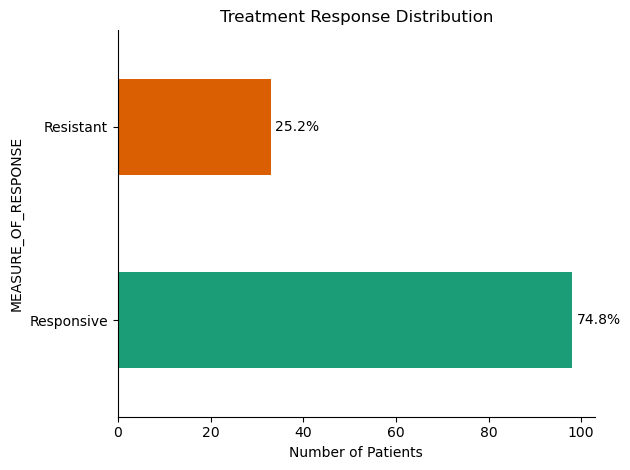

In [70]:
# Count the response categories
counts = df_clean['MEASURE_OF_RESPONSE'].value_counts()
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Create the barh plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind='barh', color=colors)

# Add percentage labels next to each bar
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

# Clean up plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("Treatment Response Distribution")
plt.tight_layout()
plt.show()

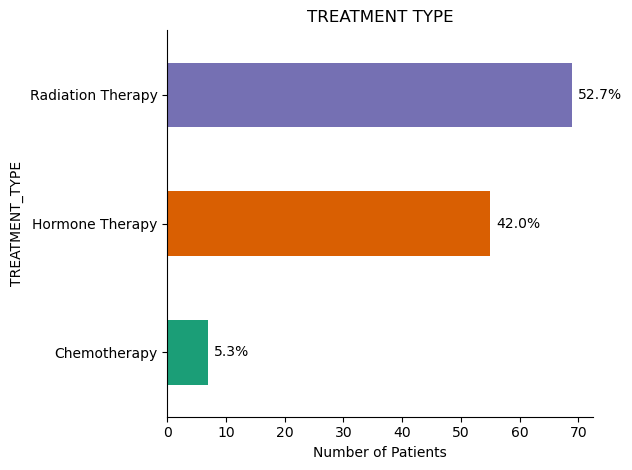

In [72]:
# Count the response categories
counts = df_clean['TREATMENT_TYPE'].value_counts().sort_values(ascending=True)
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Create the barh plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind='barh', color=colors)

# Add percentage labels next to each bar
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

# Clean up plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("TREATMENT TYPE")
plt.tight_layout()
plt.show()

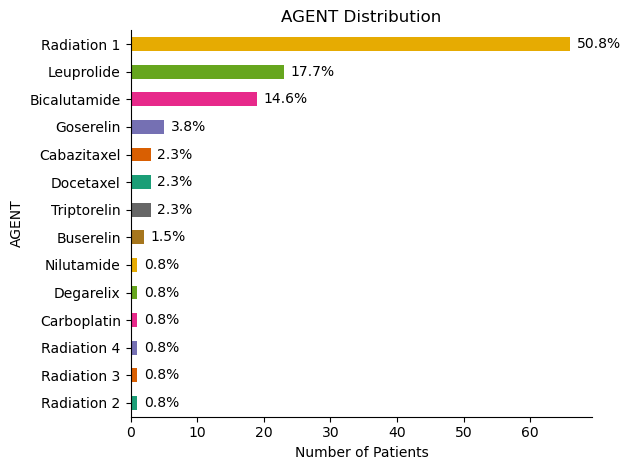

In [74]:
counts = df_clean['AGENT'].value_counts().sort_values(ascending=True)
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Create the barh plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind='barh', color=colors)

# Add percentage labels next to each bar
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

# Clean up plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("AGENT Distribution")
plt.tight_layout()
plt.show()

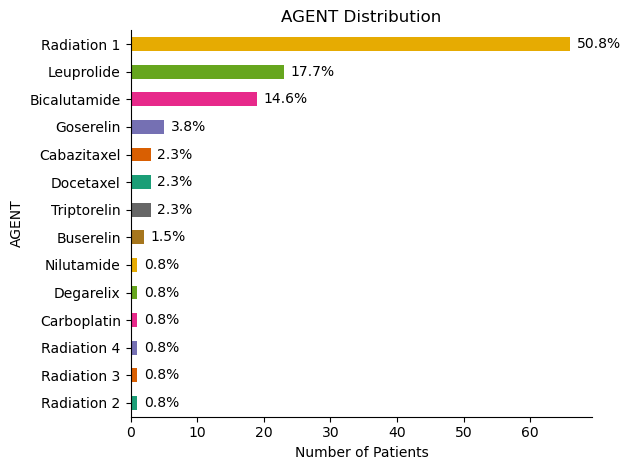

In [76]:
counts = df_clean['AGENT'].value_counts().sort_values(ascending=True)
total = counts.sum()
percentages = (counts / total * 100).round(1)

# Create the barh plot
colors = sns.color_palette('Dark2')
ax = counts.plot(kind='barh', color=colors)

# Add percentage labels next to each bar
for i, (value, percent) in enumerate(zip(counts, percentages)):
    plt.text(value + 1, i, f"{percent}%", va='center')

# Clean up plot
ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Number of Patients")
plt.title("AGENT Distribution")
plt.tight_layout()
plt.show()